## Maxout Networks in Pytorch 

This notebook is an implementation of maxout units (https://arxiv.org/abs/1302.4389) in Pytorch. My primary motivation of this was to ensure that I actually understood what maxout units were, as I found most explanations available quite opaque or incorrect! 

In [39]:
import numpy as np 
import torch 
import torch.nn as nn 
from torchvision import datasets, transforms 
from torch.autograd import Variable 
from torch.nn import init
import torch.nn.functional as F
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline 

Below we define a custom object so we can have models which contain objects which behave like lists while holding multiple modules. This is needed as we're going to store lists of layers per maxout unit. 

In [19]:
class ListModule(object):
    def __init__(self, module, prefix, *args):
        self.module = module
        self.prefix = prefix
        self.num_module = 0
        for new_module in args:
            self.append(new_module)

    def append(self, new_module):
        if not isinstance(new_module, nn.Module):
            raise ValueError('Not a Module')
        else:
            self.module.add_module(self.prefix + str(self.num_module), new_module)
            self.num_module += 1

    def __len__(self):
        return self.num_module

    def __getitem__(self, i):
        if i < 0 or i >= self.num_module:
            raise IndexError('Out of bound')
        return getattr(self.module, self.prefix + str(i))

In [3]:
learning_rate = 0.0001
batch_size = 50
n_epochs = 3
cuda = torch.cuda.is_available()

The magic normalization numbers below are actually the mean and the std of the training set of MNIST, hardcoded to save compute each run. 

In [4]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                       ])),
                       batch_size=batch_size, shuffle=True)

In [5]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                       ])),
                       batch_size=batch_size, shuffle=True)

### What is Maxout? 
Maxout is a piece of a deep learning model that sits somewhere between an activation function and a layer. It computes a nonlinearity (namely the max function) but also has learnable parameters. For reference, it is generally considered an activation but I find that terminology troublesome as it forces there to be multiple layers to max over. `¯\_(ツ)_/¯`

In their paper, Goodfellow et. al. describe the maxout activation as: 

$$h_i = max_{j \in [1,k]} z_{i,j}$$

where $h_i$ is the hidden layer output and $z = x^TW_{\cdots i,j} + b_{i,j}$ , where $x$ could be the input or the output of the previous layer. 


I find this description incredibly confusing and for a while I thought that all that you did for maxout was to compute a linear layer, group into k groups, and take the max over those groups. (the use of $k$ in the indices above should give you a hint that this interpretation is wrong) Alas, Karpathy was to the rescue here: http://cs231n.github.io/neural-networks-1/

The tldr; is that a maxout unit is an element-wise max _over_ multiple linear (or convolutional/other) layers, so for a maxout layer with two units it is computed, like so: 
$max\{W_1^Tx +b_1, W_2^Tx + b_2\}$

so in the case where $W_2^Tx+b_2 = 0$ we see that the maxout layer is a ReLU. For other properties about maxout nets, we refer back to Goodfellow's paper. 

### Define Models 
Here we define the two classes of models to test the maxout network against. 

We have an MLP and ConvNet using just ReLU's and the maxout equivalent of those networks. 

Note that for each layer which uses a maxout we have $lu$ total parameters, where $l$ is the number of parameters per unit and $u$ is the number of units. 

In [6]:
class rectifier_mlp(nn.Module):
    def __init__(self):
        super(rectifier_mlp, self).__init__()
        self.fc1 = nn.Linear(784, 1024)
        self.fc2 = nn.Linear(1024, 10)


    def forward(self, x): 
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [32]:
class maxout_mlp(nn.Module):
    def __init__(self, num_units=2):
        super(maxout_mlp, self).__init__()
        self.fc1_list = ListModule(self, "fc1_")
        self.fc2_list = ListModule(self, "fc2_")
        for _ in range(num_units):
            self.fc1_list.append(nn.Linear(784, 1024))
            self.fc2_list.append(nn.Linear(1024, 10))

    def forward(self, x): 
        x = x.view(-1, 784)
        x = self.maxout(x, self.fc1_list)
        x = F.dropout(x, training=self.training)
        x = self.maxout(x, self.fc2_list)
        return F.log_softmax(x)

    def maxout(self, x, layer_list):
        max_output = layer_list[0](x)
        for _, layer in enumerate(layer_list, start=1):
            max_output = torch.max(max_output, layer(x))
        return max_output
                            

In [8]:
class rectifier_conv_net(nn.Module):
    def __init__(self):
        super(rectifier_conv_net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, 5, padding=2)
        self.fc1 = nn.Linear(64*7*7, 1024)
        self.fc2 = nn.Linear(1024, 10)


    def forward(self, x): 
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, 64*7*7)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [9]:
class maxout_conv_net(nn.Module):
    def __init__(self, num_units=2):
        super(maxout_conv_net, self).__init__()
        self.conv1_list = ListModule(self, "conv1_")
        self.conv2_list = ListModule(self, "conv2_")
        self.fc1_list = ListModule(self, "fc1_")
        self.fc2_list = ListModule(self, "fc2_")
        for _ in range(num_units):
            self.conv1_list.append(nn.Conv2d(1, 32, 5, padding=2))
            self.conv2_list.append(nn.Conv2d(32, 64, 5, padding=2))
            self.fc1_list.append(nn.Linear(64*7*7, 1024))
            self.fc2_list.append(nn.Linear(1024, 10))

    def forward(self, x): 
        x = F.max_pool2d(self.maxout(x, self.conv1_list), 2)
        x = F.max_pool2d(self.maxout(x, self.conv2_list), 2)
        x = x.view(-1, 64*7*7)
        x = self.maxout(x, self.fc1_list)
        x = F.dropout(x, training=self.training)
        x = self.maxout(x, self.fc2_list)
        return F.log_softmax(x)

    def maxout(self, x, layer_list):
        max_output = layer_list[0](x)
        for _, layer in enumerate(layer_list, start=1):
            max_output = torch.max(max_output, layer(x))
        return max_output
                            

In [10]:
def train(epoch,  net, train_loss, train_acc): 
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    net.train()
    for batch_idx, (data, target) in enumerate(train_loader): 
        if cuda:
            data, target = Variable(data).cuda(0), Variable(target).cuda(0)
        else:
            data, target = Variable(data), Variable(target)
            
        optimizer.zero_grad()
        output = net(data)
        loss = F.cross_entropy(output, target)
        train_loss.append(loss.data[0])
        loss.backward()
        optimizer.step()
        prediction = output.data.max(1)[1]
        accuracy = prediction.eq(target.data).sum()*1.0/batch_size*100.0 
        train_acc.append(accuracy)
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))

In [11]:
def test(epoch, net):
    net.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = net(data)
        test_loss += F.cross_entropy(output, target).data[0]
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    test_loss = test_loss
    test_loss /= len(test_loader) # loss function already averages over batch size
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [12]:
if cuda:
    net_relu = rectifier_conv_net().cuda()
else:
    net_relu = rectifier_conv_net()
relu_loss = [] 
relu_acc = []
for epoch in range(n_epochs): 
    train(epoch, net_relu, relu_loss, relu_acc)
    test(epoch, net_relu)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.290519
Train Epoch: 0 [5000/60000 (8%)]	Loss: 0.285147
Train Epoch: 0 [10000/60000 (17%)]	Loss: 0.146821
Train Epoch: 0 [15000/60000 (25%)]	Loss: 0.272205
Train Epoch: 0 [20000/60000 (33%)]	Loss: 0.221471
Train Epoch: 0 [25000/60000 (42%)]	Loss: 0.224038
Train Epoch: 0 [30000/60000 (50%)]	Loss: 0.274867
Train Epoch: 0 [35000/60000 (58%)]	Loss: 0.038073
Train Epoch: 0 [40000/60000 (67%)]	Loss: 0.135521
Train Epoch: 0 [45000/60000 (75%)]	Loss: 0.104026
Train Epoch: 0 [50000/60000 (83%)]	Loss: 0.293587
Train Epoch: 0 [55000/60000 (92%)]	Loss: 0.146798

Test set: Average loss: 0.0731, Accuracy: 9766/10000 (98%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.049651
Train Epoch: 1 [5000/60000 (8%)]	Loss: 0.025212
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.130879
Train Epoch: 1 [15000/60000 (25%)]	Loss: 0.078905
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.039131
Train Epoch: 1 [25000/60000 (42%)]	Loss: 0.010621
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.037744
Tra

In [13]:
if cuda:
    net_maxout = maxout_conv_net(num_units=5).cuda() #this uses 5 "maxout units" per "layer" 
else:
    net_maxout = maxout_conv_net(num_units=5)
maxout_loss = [] 
maxout_acc = []
for epoch in range(n_epochs): 
    train(epoch, net_maxout, maxout_loss, maxout_acc)
    test(epoch, net_maxout)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.363012
Train Epoch: 0 [5000/60000 (8%)]	Loss: 0.478533
Train Epoch: 0 [10000/60000 (17%)]	Loss: 0.089672
Train Epoch: 0 [15000/60000 (25%)]	Loss: 0.102352
Train Epoch: 0 [20000/60000 (33%)]	Loss: 0.224029
Train Epoch: 0 [25000/60000 (42%)]	Loss: 0.155579
Train Epoch: 0 [30000/60000 (50%)]	Loss: 0.085204
Train Epoch: 0 [35000/60000 (58%)]	Loss: 0.110757
Train Epoch: 0 [40000/60000 (67%)]	Loss: 0.073194
Train Epoch: 0 [45000/60000 (75%)]	Loss: 0.145176
Train Epoch: 0 [50000/60000 (83%)]	Loss: 0.027566
Train Epoch: 0 [55000/60000 (92%)]	Loss: 0.060530

Test set: Average loss: 0.0493, Accuracy: 9836/10000 (98%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.097051
Train Epoch: 1 [5000/60000 (8%)]	Loss: 0.011630
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.023141
Train Epoch: 1 [15000/60000 (25%)]	Loss: 0.032429
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.120462
Train Epoch: 1 [25000/60000 (42%)]	Loss: 0.072779
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.118338
Tra

In [14]:
if cuda:
    mlp_relu = rectifier_mlp().cuda() 
else:
    mlp_relu = rectifier_mlp()
relu_mlp_loss = [] 
relu_mlp_acc = []
for epoch in range(n_epochs): 
    train(epoch, mlp_relu, relu_mlp_loss, relu_mlp_acc)
    test(epoch, mlp_relu)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.348691
Train Epoch: 0 [5000/60000 (8%)]	Loss: 0.682529
Train Epoch: 0 [10000/60000 (17%)]	Loss: 0.646795
Train Epoch: 0 [15000/60000 (25%)]	Loss: 0.302137
Train Epoch: 0 [20000/60000 (33%)]	Loss: 0.265129
Train Epoch: 0 [25000/60000 (42%)]	Loss: 0.374851
Train Epoch: 0 [30000/60000 (50%)]	Loss: 0.476626
Train Epoch: 0 [35000/60000 (58%)]	Loss: 0.351321
Train Epoch: 0 [40000/60000 (67%)]	Loss: 0.422480
Train Epoch: 0 [45000/60000 (75%)]	Loss: 0.324298
Train Epoch: 0 [50000/60000 (83%)]	Loss: 0.330992
Train Epoch: 0 [55000/60000 (92%)]	Loss: 0.216023

Test set: Average loss: 0.2178, Accuracy: 9364/10000 (94%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.397623
Train Epoch: 1 [5000/60000 (8%)]	Loss: 0.346569
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.124273
Train Epoch: 1 [15000/60000 (25%)]	Loss: 0.188086
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.086380
Train Epoch: 1 [25000/60000 (42%)]	Loss: 0.271180
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.160728
Tra

In [34]:
if cuda:
    mlp_maxout = maxout_mlp(num_units=5).cuda() 
else:
    mlp_maxout = maxout_mlp(num_units=5)
maxout_mlp_loss = [] 
maxout_mlp_acc = []
for epoch in range(n_epochs): 
    train(epoch, mlp_maxout, maxout_mlp_loss, maxout_mlp_acc)
    test(epoch, mlp_maxout)

Train Epoch: 0 [0/60000 (0%)]	Loss: 3.156196
Train Epoch: 0 [5000/60000 (8%)]	Loss: 0.565568
Train Epoch: 0 [10000/60000 (17%)]	Loss: 0.644320
Train Epoch: 0 [15000/60000 (25%)]	Loss: 0.355569
Train Epoch: 0 [20000/60000 (33%)]	Loss: 0.463959
Train Epoch: 0 [25000/60000 (42%)]	Loss: 0.441238
Train Epoch: 0 [30000/60000 (50%)]	Loss: 0.456167
Train Epoch: 0 [35000/60000 (58%)]	Loss: 0.370821
Train Epoch: 0 [40000/60000 (67%)]	Loss: 0.294294
Train Epoch: 0 [45000/60000 (75%)]	Loss: 0.256920
Train Epoch: 0 [50000/60000 (83%)]	Loss: 0.238175
Train Epoch: 0 [55000/60000 (92%)]	Loss: 0.527092

Test set: Average loss: 0.5914, Accuracy: 9490/10000 (95%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.281222
Train Epoch: 1 [5000/60000 (8%)]	Loss: 0.229687
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.449179
Train Epoch: 1 [15000/60000 (25%)]	Loss: 0.501339
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.267238
Train Epoch: 1 [25000/60000 (42%)]	Loss: 0.406091
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.285968
Tra

## Plots! 
Here I show the accuracy and loss of both the MLP and the ConvNet versions of the ReLU and maxout nets. 

These plots aren't incredibly informative as MNIST is so easy that both nets do very well quickly. That said, it is clear from the plots and numbers above that the maxout network is doing better than the ReLU net. 

/cse/home/duncanw/summer/env/local/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


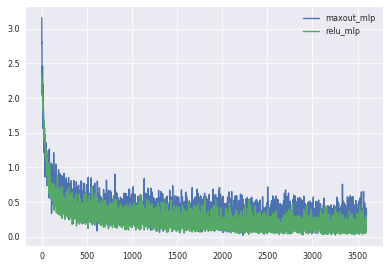

In [41]:
sns.set_context("paper")
plot1, = plt.plot(maxout_mlp_loss, label='maxout_mlp')
plot2, = plt.plot(relu_mlp_loss, label='relu_mlp')
plt.legend(handles=[plot1, plot2])


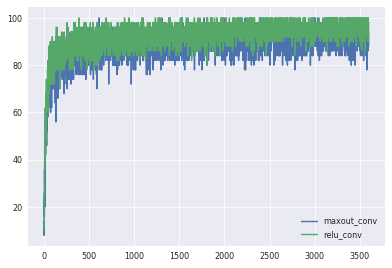

In [42]:
plot1, = plt.plot(np.arange(len(maxout_mlp_acc)), maxout_mlp_acc, label='maxout_conv')
plot2, = plt.plot(np.arange(len(relu_mlp_acc)), relu_mlp_acc, label='relu_conv')
plt.legend(handles=[plot1, plot2])


## Conclusion 

Maxout units are cool! I'm interested to see how much of an improvement these make on lower dimensional linear layers at the end of large convolutional nets and will be testing that in the coming weeks. The lack of saturation might help gradients back prop, while not requiring that you have many times more parameters for you entire model. 

This work also made me realize viscerally how important clear explanations are! There are *so many* incorrect implementations that you can find online of maxout units, so hopefully this will serve as a guide for people who were in my position a couple of days ago. 

### References 
- https://arxiv.org/pdf/1302.4389.pdf (original paper) 
- http://cs231n.github.io/neural-networks-1/ (Karpathy to the rescue)
- http://www.simon-hohberg.de/2015/07/19/maxout.html (really helpful visualizations) 
- tons of Pytorch forum posts, thanks y'all 